In [ ]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, LassoLars, ElasticNetCV, Ridge, Lasso
from sklearn.model_selection import train_test_split
import random as r
import matplotlib.pyplot as plt
from collections import Counter

In [189]:
# -----------------------------
# 1. Load your datasets
# -----------------------------
print("Loading datasets...")
reviews_df = pd.read_csv("./archive/dataset.csv")  # columns: app_id, app_name, review_text


Loading datasets...


In [190]:
tags_df = pd.read_csv("output.csv")        # columns: APPID, tags

# Convert string representation of dict to actual dict
tags_df['tags'] = tags_df['tags'].apply(lambda x: literal_eval(x))
print(tags_df.head())

# Optional: Keep only tag names (ignore counts)
tags_df['tags'] = tags_df['tags'].apply(lambda d: list(d.keys()) if isinstance(d, dict) else d)

    APPID                                               tags
0      10  {'Action': 5504, 'FPS': 4929, 'Multiplayer': 3...
1    1002  {'2D Fighter': 47, 'Martial Arts': 41, 'Intent...
2  100400       {'Animation & Modeling': 23, 'Software': 11}
3   10090  {'Zombies': 1198, 'World War II': 903, 'FPS': ...
4  100980  {'Animation & Modeling': 38, 'Utilities': 22, ...


In [325]:
def filter_rare_tags(tags_df, min_count=5):
    """
    Filters out tags that occur less than min_count times across all games.
    
    Args:
        tags_df (pd.DataFrame): columns ['APPID', 'tags'], where 'tags' is a list of tag names
        min_count (int): minimum number of occurrences required to keep a tag
    
    Returns:
        pd.DataFrame: filtered tags_df
    """
    # Flatten all tags into a single list
    all_tags = [tag for tags in tags_df['tags'] for tag in tags]
    tag_counts = Counter(all_tags)
    print(len(tag_counts), tag_counts)
    # Keep only tags above threshold
    allowed_tags = {tag for tag, count in tag_counts.items() if count >= min_count}
    print(len(allowed_tags), allowed_tags)
    # Filter tags per game
    def keep_tags(tag_list):
        return [tag for tag in tag_list if tag in allowed_tags]
    
    tags_df['tags'] = tags_df['tags'].apply(keep_tags)
    
    # Optionally, drop games with no tags left after filtering
    tags_df = tags_df[tags_df['tags'].str.len() > 0].reset_index(drop=True)
    
    return tags_df

# Apply rare tag filtering
tags_df = filter_rare_tags(tags_df, min_count=5)
print("Tags after rare tag filtering:", tags_df.shape)
print(tags_df)

421 Counter({'Indie': 6304, 'Action': 5048, 'Singleplayer': 4482, 'Adventure': 4335, 'Casual': 3422, 'Strategy': 2523, 'Multiplayer': 2068, 'Simulation': 2068, 'RPG': 1991, '2D': 1990, 'Atmospheric': 1737, 'Puzzle': 1722, 'Great Soundtrack': 1630, 'Story Rich': 1327, 'Shooter': 1198, 'Sci-fi': 1196, 'First-Person': 1134, 'Platformer': 1117, 'Funny': 1100, 'Fantasy': 1089, 'Difficult': 1086, 'Open World': 1061, 'Co-op': 1060, 'Pixel Graphics': 1049, 'Horror': 1044, 'Female Protagonist': 1041, 'Arcade': 953, 'Retro': 950, 'Free to Play': 887, 'Point & Click': 824, 'Anime': 813, 'Classic': 802, 'FPS': 776, 'Early Access': 774, 'Exploration': 757, 'Comedy': 755, 'Survival': 723, 'Family Friendly': 722, 'Sandbox': 712, 'Third Person': 690, 'Cute': 646, 'Turn-Based': 627, 'Space': 626, 'VR': 605, 'Gore': 579, 'Controller': 538, 'Tactical': 495, 'Local Co-Op': 484, 'Local Multiplayer': 483, 'Colorful': 480, 'Psychological Horror': 466, 'Sports': 453, 'Visual Novel': 440, 'Side Scroller': 435,

In [ ]:
# -----------------------------
# 2. Aggregate reviews per game (only games with tags available)
# -----------------------------

print("Aggregating reviews per game...")

reviews_df['app_id'] = reviews_df['app_id'].astype(int)
tags_df['APPID'] = tags_df['APPID'].astype(int)

# Filter reviews to only include games present in tags_df
reviews_with_tags = reviews_df[reviews_df['app_id'].isin(tags_df['APPID'])]
print(reviews_with_tags.head(5))

# Convert review_text to string
reviews_with_tags['review_text'] = reviews_with_tags['review_text'].astype(str)

# Filter out reviews shorter than 3 words
reviews_with_tags = reviews_with_tags.loc[reviews_with_tags['review_text'].str.split().str.len() >= 3]

print("Filtered reviews shape:", reviews_with_tags.shape)

# Aggregate reviews per game and keep app_name
game_reviews = (
    reviews_with_tags.groupby('app_id')
    .agg({
        'review_text': lambda texts: " ".join(texts),
        'app_name': 'first'  # keep the first app_name per app_id
    })
    .reset_index()
)
print("Aggregated reviews shape:", game_reviews.shape)

# Merge with filtered tags
game_reviews = game_reviews.merge(tags_df, left_on='app_id', right_on='APPID')
print("Merged game_reviews shape:", game_reviews.shape)

print("Sample data:")
print(game_reviews.head())


Aggregating reviews per game...
   app_id        app_name                                        review_text  \
0      10  Counter-Strike                                    Ruined my life.   
1      10  Counter-Strike  This will be more of a ''my experience with th...   
2      10  Counter-Strike                      This game saved my virginity.   
3      10  Counter-Strike  • Do you like original games? • Do you like ga...   
4      10  Counter-Strike           Easy to learn, hard to master.             

   review_score  review_votes  
0             1             0  
1             1             1  
2             1             0  
3             1             0  
4             1             1  


C:\Users\joris\AppData\Local\Temp\ipykernel_21196\322640611.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_with_tags['review_text'] = reviews_with_tags['review_text'].astype(str)


Filtered reviews shape: (6258189, 5)
Tags after rare tag filtering: (9962, 2)
Aggregated reviews shape: (9960, 3)
Merged game_reviews shape: (9960, 5)
Sample data:
   app_id                                        review_text  \
0      10  Ruined my life. This will be more of a ''my ex...   
1      20  When I got this for Christmas in 1999 along wi...   
2      30  Even though its old, its better than Call of D...   
3      40  Buy this game and join the community of one Th...   
4      50  This is the first game created by Gearbox - th...   

                    app_name  APPID  \
0             Counter-Strike     10   
1      Team Fortress Classic     20   
2              Day of Defeat     30   
3         Deathmatch Classic     40   
4  Half-Life: Opposing Force     50   

                                                tags  
0  [Action, FPS, Multiplayer, Shooter, Classic, T...  
1  [Action, FPS, Multiplayer, Classic, Hero Shoot...  
2  [FPS, World War II, Multiplayer, Shooter, Acti..

In [309]:
# -----------------------------
# 3. Encode text to embeddings
# -----------------------------
print("Encoding text to embeddings...")
model = SentenceTransformer("all-MiniLM-L6-v2")
data = model.encode(game_reviews['review_text'].tolist(), show_progress_bar=True)


Encoding text to embeddings...


Batches: 100%|██████████| 312/312 [09:37<00:00,  1.85s/it]


In [ ]:
def save_embeddings(embeddings, filename):
    """
    Save embeddings to disk.

    Parameters:
    - embeddings: numpy array of shape (num_samples, embedding_dim)
    - filename: str, path to save the .npy file
    """
    np.save(filename, embeddings)
    print(f"Embeddings saved to {filename}")

# Usage example:
save_embeddings(data, "game_review_embeddings.npy")

In [310]:
# -----------------------------
# 4. Encode tags to multilabel format
# -----------------------------
print("Encoding tags to multilabel format...")
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(game_reviews['tags'])

Encoding tags to multilabel format...


In [327]:
# -----------------------------
# 5. Train/Test split
# -----------------------------
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test, train_ids, test_ids, train_names, test_names = train_test_split(
    data, y, game_reviews['app_id'], game_reviews['app_name'], test_size=0.2, random_state=42
)

Splitting data into train and test sets...


In [312]:
# -----------------------------
# 6. Train multilabel classifier
# -----------------------------
print("Training multilabel classifier...")
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
clf.fit(X_train, y_train)

Training multilabel classifier...


,estimator,LogisticRegre...max_iter=1000)
,n_jobs,None
,verbose,0
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None


In [398]:
# -----------------------------
# 7. Predict and align with game info
# -----------------------------

actual_tags = mlb.inverse_transform(y_test)

# Get probabilities
probs = clf.predict_proba(X_test)

# Pick top 5 tags per game
def get_top_n_tags(probs, top_n=20):
    top_n_pred_tags = []
    for prob_row in probs:
        top_indices = prob_row.argsort()[-top_n:][::-1]  # indices of top N probs
        top_tags = [mlb.classes_[i] for i in top_indices]
        top_n_pred_tags.append(top_tags)
    return top_n_pred_tags

top_n_pred_tags = get_top_n_tags(probs, top_n=20)

def get_treshhold_tags(probs, threshold=0.25):
    dynamic_pred_tags = []

    for prob_row in probs:
        # Get indices where probability > threshold
        tag_indices = np.where(prob_row > threshold)[0]

        if len(tag_indices) == 0:
            # fallback: pick the top 1 tag
            tag_indices = [np.argmax(prob_row)]

        tags = [mlb.classes_[i] for i in tag_indices]
        dynamic_pred_tags.append(tags)
    return dynamic_pred_tags          
        

top_n_pred_tags = get_treshhold_tags(probs, threshold=0.35)
# top_n_pred_tags = get_top_n_tags(probs, top_n=20)

# for i, l in enumerate(top_n_pred_tags):
#      top_n_pred_tags[i] =  top_n_pred_tags[i][20:]


# Example: print top 5 predicted tags for first 5 games
# gam = r.randint(0, len(test_names)-1)
# for i in range(gam, gam+5):
#     print(f"{test_names.iloc[i]} (app_id={test_ids.iloc[i]})")
#     print("  Predicted tags:", top_n_pred_tags[i])  # only show tags not in actual
#     print("  Actual tags   :", actual_tags[i])
#     print(f"{len(set(top_n_pred_tags[i]) & set(actual_tags[i]))}/{len(actual_tags[i])}", "tags correct")
#     print()
# -----------------------------
gam = r.randint(0, len(test_names)-1)
for i in range(gam, gam+5):
    print(f"{test_names.iloc[i]} (app_id={test_ids.iloc[i]})")
    print("  Predicted tags:", top_n_pred_tags[i][:len(actual_tags[i])])
    print("  Actual tags   :", actual_tags[i])
    print(f"{len(set(top_n_pred_tags[i][:len(actual_tags[i])]) & set(actual_tags[i]))}/{len(actual_tags[i])}", "tags correct")
    print()


Munin (app_id=281750)
  Predicted tags: ['Adventure', 'Casual', 'Great Soundtrack', 'Indie', 'Puzzle', 'Singleplayer']
  Actual tags   : ('2D', '2D Platformer', 'Abstract', 'Adventure', 'Atmospheric', 'Beautiful', 'Casual', 'Dark', 'Difficult', 'Female Protagonist', 'Hand-drawn', 'Indie', 'Logic', 'Mythology', 'Physics', 'Platformer', 'Puzzle', 'Puzzle-Platformer', 'Singleplayer', 'Surreal')
5/20 tags correct

Space Rangers: Quest (app_id=503450)
  Predicted tags: ['Action', 'Adventure', 'Indie', 'Open World', 'RPG']
  Actual tags   : ('Adventure', 'RPG', 'Sci-fi', 'Space', 'Text-Based')
2/5 tags correct

Disney-Pixar Brave (app_id=301830)
  Predicted tags: ['Action', 'Adventure', 'Casual', 'Indie', 'Singleplayer']
  Actual tags   : ('Action', 'Adventure', 'Family Friendly', 'Fantasy', 'Female Protagonist', 'Hack and Slash', 'Puzzle', 'Singleplayer')
3/8 tags correct

DRAKERZ-Confrontation (app_id=266030)
  Predicted tags: ['Action', 'Free to Play', 'Indie']
  Actual tags   : ('Action'

In [399]:
# Example: pred_tags = [['Action','RPG'], ['Action','Multiplayer'], ['RPG','Multiplayer']]
# Flatten the list of lists

def find_top_x(li, x=10, print_output=True):
    flat = np.array([item for sublist in li for item in sublist])

    # Get unique tags and counts
    unique, counts = np.unique(flat, return_counts=True)

    # Sort tags by descending frequency
    sorted_indices = np.argsort(-counts)
    most_common_items = unique[sorted_indices]
    most_common_counts = counts[sorted_indices]

    # Print top 10 tags
    if print_output:
        print("Top tags:")
        for item, count in zip(most_common_items[:x], most_common_counts[:x]):
            print(f"{item}: {count}")
    return most_common_items[:x], most_common_counts[:x]

X=25
top_pred = find_top_x(top_n_pred_tags, x=X, print_output=False)
top_act = find_top_x(actual_tags, x=X, print_output=False)

print(len(top_n_pred_tags), len(actual_tags))
df_compare = pd.DataFrame({
    'pred_Tag': [t for t in top_pred[0]],
    'pred_count': [s for s in top_pred[1]],
    'act_Tag': [t for t in top_act[0]],
    'act_count': [s for s in top_act[1]]
})

df_compare


1992 1992


,pred_Tag,pred_count,act_Tag,act_count
0,Indie,1725,Indie,1239
1,Singleplayer,1449,Action,1029
2,Action,1362,Singleplayer,931
3,Adventure,1226,Adventure,859
4,Casual,807,Casual,707
5,Strategy,454,Strategy,512
6,Multiplayer,389,Simulation,447
7,Simulation,383,Multiplayer,424
8,RPG,303,2D,396
9,Puzzle,289,RPG,384


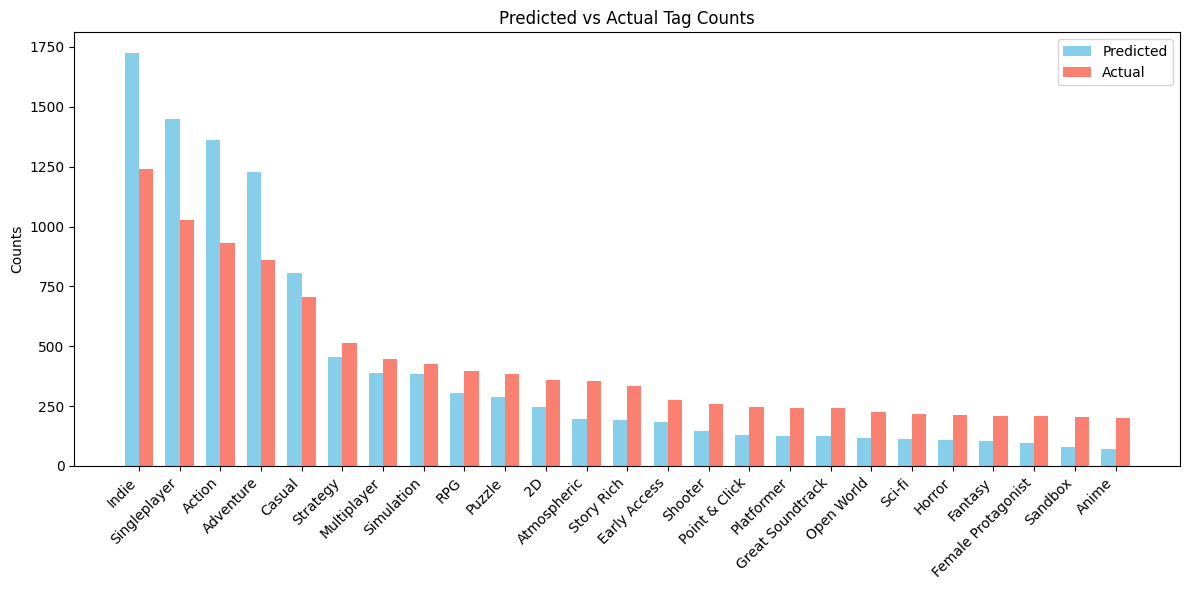

In [400]:

# We'll plot the top 10 predicted tags for clarity
top_n = X
df_top = df_compare.head(top_n)

x = np.arange(top_n)  # positions for each tag
width = 0.35          # width of bars

fig, ax = plt.subplots(figsize=(12,6))

# Bars
ax.bar(x - width/2, df_top['pred_count'], width, label='Predicted', color='skyblue')
ax.bar(x + width/2, df_top['act_count'], width, label='Actual', color='salmon')

# Labels
ax.set_ylabel('Counts')
ax.set_title('Predicted vs Actual Tag Counts')
ax.set_xticks(x)
ax.set_xticklabels(df_top['pred_Tag'], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

In [401]:

def plot_tag_count_distribution_hist(pred_counts, actual_counts, bins=20, title="Tag Count Distribution"):
    """
    Plots the distribution of tag counts using a histogram with bins and a line overlay.
    
    Args:
        pred_counts (array-like): counts of each predicted tag
        actual_counts (array-like): counts of each actual tag
        bins (int or sequence): number of bins or bin edges
        title (str): plot title
    """
    plt.figure(figsize=(12,6))
    
    # Histogram for actual counts
    counts_actual, bin_edges = np.histogram(actual_counts, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.bar(bin_centers, counts_actual, width=(bin_edges[1]-bin_edges[0])*0.4, alpha=0.6,
            label='Actual', color='salmon', edgecolor='black')
    plt.plot(bin_centers, counts_actual, color='red', marker='o', linestyle='-', label='Actual (line)')
    
    # Histogram for predicted counts
    counts_pred, _ = np.histogram(pred_counts, bins=bin_edges)
    plt.bar(bin_centers + (bin_edges[1]-bin_edges[0])*0.4, counts_pred, width=(bin_edges[1]-bin_edges[0])*0.4,
            alpha=0.6, label='Predicted', color='skyblue', edgecolor='black')
    plt.plot(bin_centers, counts_pred, color='blue', marker='o', linestyle='-', label='Predicted (line)')
    
    plt.xlabel("Number of occurrences of a tag")
    plt.ylabel("Number of tags in that bin")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [402]:
def tag_distribution_report(tag_tuple, name="Tag Distribution"):
    """
    Generate a report on the distribution of tag counts.
    tag_tuple: tuple (tags_list, counts_list)
    name: label of the dataset (e.g. 'Predicted' or 'Actual')
    """
    tags, counts = tag_tuple
    counts = np.array(counts)

    report = {
        "Dataset Name": name,
        "Total Unique Tags": len(tags),
        "Total Tag Assignments": counts.sum(),
        "Mean Tag Frequency": counts.mean(),
        "Median Tag Frequency": np.median(counts),
        "Min Tag Frequency": counts.min(),
        "Max Tag Frequency": counts.max(),
        "Std Dev": counts.std(),
        "10th Percentile": np.percentile(counts, 10),
        "25th Percentile": np.percentile(counts, 25),
        "50th Percentile": np.percentile(counts, 50),
        "75th Percentile": np.percentile(counts, 75),
        "90th Percentile": np.percentile(counts, 90),
        "Tags Occurring Once": np.sum(counts == 1),
        "Tags Occurring <= 5": np.sum(counts <= 5),
        "Top 10 Tags Coverage (%)": round(100 * counts[:10].sum() / counts.sum(), 2)
    }

    return pd.DataFrame.from_dict(report, orient='index', columns=[name])


                          Predicted Tags
Dataset Name              Predicted Tags
Total Unique Tags                    127
Total Tag Assignments              12026
Mean Tag Frequency             94.692913
Median Tag Frequency                12.0
Min Tag Frequency                      1
Max Tag Frequency                   1725
Std Dev                       266.095759
10th Percentile                      1.0
25th Percentile                      3.0
50th Percentile                     12.0
75th Percentile                     49.5
90th Percentile                    187.6
Tags Occurring Once                   15
Tags Occurring <= 5                   43
Top 10 Tags Coverage (%)           69.74 
                           Actual Tags
Dataset Name              Actual Tags
Total Unique Tags                 415
Total Tag Assignments           22574
Mean Tag Frequency          54.395181
Median Tag Frequency             18.0
Min Tag Frequency                   1
Max Tag Frequency                12

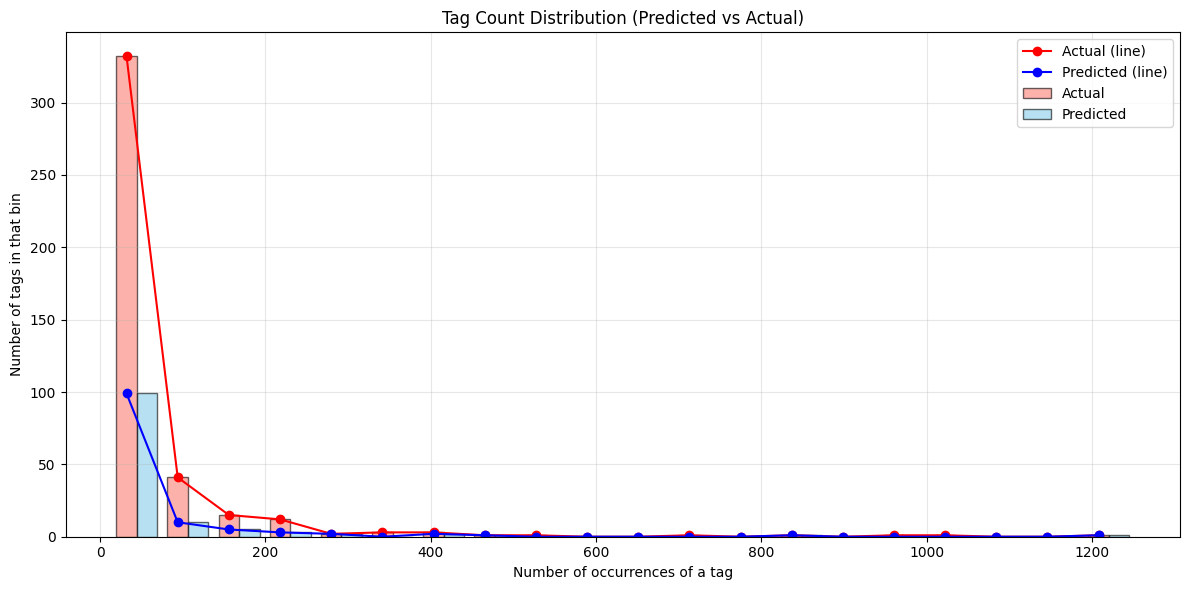

In [403]:
top_pred = find_top_x(top_n_pred_tags, x=len(top_n_pred_tags), print_output=False)
top_act = find_top_x(actual_tags, x=len(actual_tags), print_output=False)

print(tag_distribution_report(top_pred, name="Predicted Tags"), "\n",
tag_distribution_report(top_act, name="Actual Tags"))
plot_tag_count_distribution_hist(top_pred[1], top_act[1], title="Tag Count Distribution (Predicted vs Actual)")

In [404]:
# Convert top-N predicted tag names to a binary matrix
y_pred = np.zeros_like(y_test)

for i, tags in enumerate(top_n_pred_tags):
    for tag in tags:
        if tag in mlb.classes_:
            idx = list(mlb.classes_).index(tag)
            y_pred[i, idx] = 1



In [405]:
from sklearn.metrics import hamming_loss, f1_score, precision_score, recall_score

# y_test: actual multilabel binary matrix
# y_pred: predicted multilabel binary matrix

# Hamming Loss
hl = hamming_loss(y_test, y_pred)
print("Hamming Loss:", hl)

# Micro-averaged precision, recall, F1 (across all games)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')

print(f"Micro Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

# Macro-averaged F1 (average per tag)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"Macro F1 (per tag): {f1_macro:.3f}")


Hamming Loss: 0.0241202339047401
Micro Precision: 0.598, Recall: 0.318, F1: 0.415
Macro F1 (per tag): 0.075


C:\Users\joris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [406]:
import joblib
import os

def save_trained_model(model, filename, folder="models"):
    """
    Save a trained model to disk.
    
    Args:
        model: trained classifier (e.g., OneVsRestClassifier)
        filename: name of the file (without folder)
        folder: folder to save models (will be created if not exists)
    """
    os.makedirs(folder, exist_ok=True)
    filepath = os.path.join(folder, filename)
    joblib.dump(model, filepath)
    print(f"Model saved to {filepath}")

def load_trained_model(filename, folder="models"):
    """
    Load a trained model from disk.
    
    Args:
        filename: name of the file
        folder: folder where models are stored
    
    Returns:
        Loaded model
    """
    filepath = os.path.join(folder, filename)
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"No model found at {filepath}")
    model = joblib.load(filepath)
    print(f"Model loaded from {filepath}")
    return model


Model loaded from models\LogisticRegression_model.joblib
Model loaded from models\LinearSVC_model.joblib
Model loaded from models\SGDClassifier_model.joblib
Model loaded from models\LightGBM_model.joblib

Training LogisticRegression...
Predicting LogisticRegression...


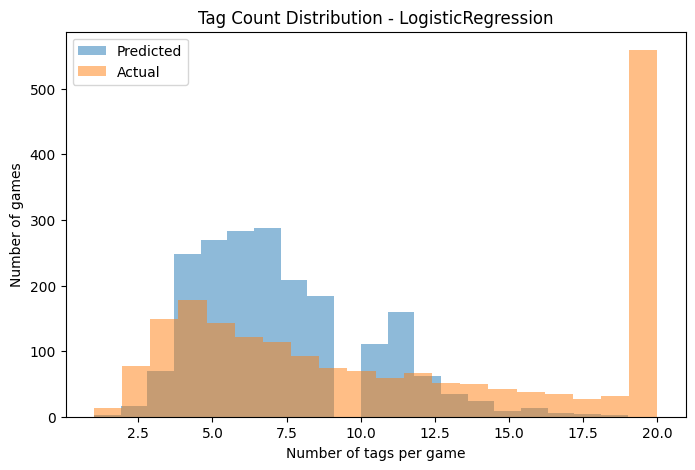


Training LinearSVC...
Predicting LinearSVC...


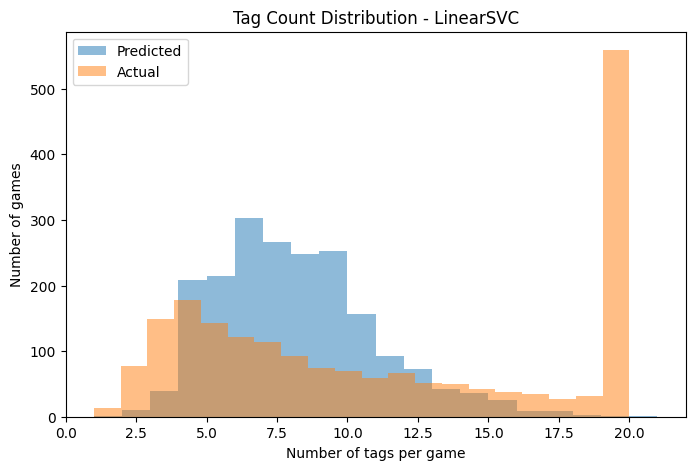


Training SGDClassifier...
Predicting SGDClassifier...


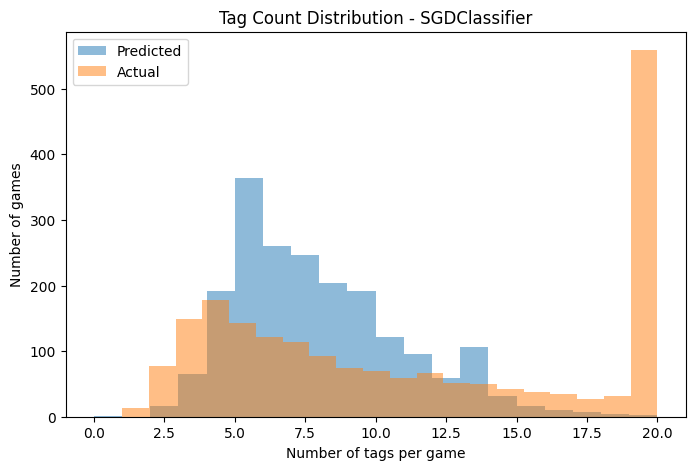


Training LightGBM...
Predicting LightGBM...


C:\Users\joris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\joris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\joris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\joris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-pac

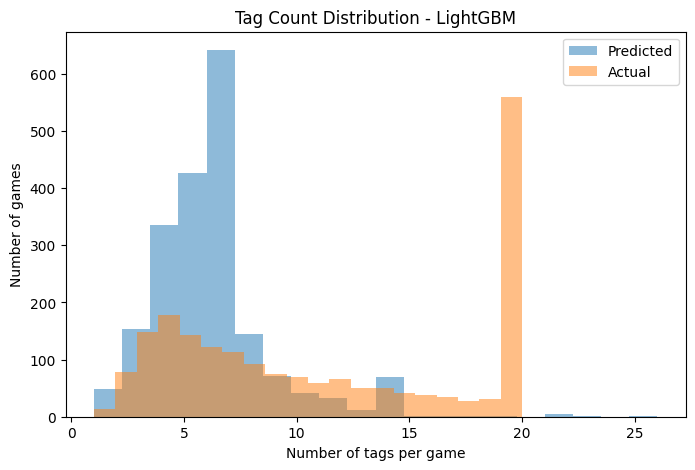

In [407]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier
from lightgbm import LGBMClassifier

def compare_multilabel_models(X_train, y_train, X_test, y_test, mlb, train=False):
    models = {
        "LogisticRegression": OneVsRestClassifier(LogisticRegression(max_iter=1000)) if train else load_trained_model("LogisticRegression_model.joblib"),
        "LinearSVC": OneVsRestClassifier(CalibratedClassifierCV(LinearSVC(max_iter=1000))) if train else load_trained_model("LinearSVC_model.joblib"),
        "SGDClassifier": OneVsRestClassifier(SGDClassifier(loss='log_loss', max_iter=1000)) if train else load_trained_model("SGDClassifier_model.joblib"),
        "LightGBM": OneVsRestClassifier(LGBMClassifier(
            objective='binary',
            boosting_type='gbdt',
            num_leaves=31,
            learning_rate=0.05,
            n_estimators=200
        )) if train else load_trained_model("LightGBM_model.joblib"),
    }
    
    results = []

    for name, clf in models.items():
        print(f"\nTraining {name}...")
        if train:
            clf.fit(X_train, y_train)
        
        print(f"Predicting {name}...")
        # Use dynamic threshold (e.g., 0.3) for probability models
        if hasattr(clf, "predict_proba"):
            probs = clf.predict_proba(X_test)
            threshold = 0.3
            y_pred = list([[mlb.classes_[i] for i, p in enumerate(row) if p >= threshold] 
                               if row.any() else [mlb.classes_[np.argmax(row)]] 
                               for row in probs])
            # Convert back to binary array for metrics
            y_pred_binary = mlb.transform(y_pred)
        else:
            y_pred_binary = clf.predict(X_test)
            # For visualization
            y_pred = mlb.inverse_transform(y_pred_binary)
        
        # Metrics
        hloss = hamming_loss(y_test, y_pred_binary)
        micro_p = precision_score(y_test, y_pred_binary, average='micro', zero_division=0)
        micro_r = recall_score(y_test, y_pred_binary, average='micro', zero_division=0)
        micro_f1 = f1_score(y_test, y_pred_binary, average='micro', zero_division=0)
        macro_f1 = f1_score(y_test, y_pred_binary, average='macro', zero_division=0)
        
        results.append({
            "Model": name,
            "Hamming Loss": hloss,
            "Micro Precision": micro_p,
            "Micro Recall": micro_r,
            "Micro F1": micro_f1,
            "Macro F1": macro_f1
        })
        
        # Visualize predicted vs actual tag counts
        pred_counts = np.array([len(tags) for tags in y_pred])
        act_counts = np.array([len(tags) for tags in mlb.inverse_transform(y_test)])
        
        plt.figure(figsize=(8,5))
        plt.hist(pred_counts, bins=20, alpha=0.5, label='Predicted')
        plt.hist(act_counts, bins=20, alpha=0.5, label='Actual')
        plt.xlabel("Number of tags per game")
        plt.ylabel("Number of games")
        plt.title(f"Tag Count Distribution - {name}")
        plt.legend()
        plt.show()
    
    return pd.DataFrame(results), models

# Example usage:
# results_df = compare_multilabel_models(X_train, y_train, X_test, y_test, mlb)
# print(results_df)
train = False
results_df, trained_models = compare_multilabel_models(X_train, y_train, X_test, y_test, mlb, train=train)
if train:
    for i, model_name in enumerate(trained_models.keys()):
        save_trained_model(trained_models[model_name], f"{model_name}_model.joblib")

In [408]:
print(results_df)

                Model  Hamming Loss  Micro Precision  Micro Recall  Micro F1  \
0  LogisticRegression      0.025040         0.554224      0.356561  0.433943   
1           LinearSVC      0.024998         0.552780      0.373483  0.445778   
2       SGDClassifier      0.025304         0.545430      0.359794  0.433578   
3            LightGBM      0.024943         0.568216      0.305528  0.397384   

   Macro F1  
0  0.085331  
1  0.164042  
2  0.093242  
3  0.070338  
